In [160]:
# Install necessary libraries
import json
import pandas as pd
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [161]:
# Mount:
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [162]:
# Read json file
def readJsonData(JSON_FILE_PATH):
  data = None
  try:
    with open(JSON_FILE_PATH, 'r') as f:
        data = json.load(f)
    print("✅ JSON file loaded successfully.")

    metadata = data.get('metadata', {})
    print(f"\n--- Session Metadata ---")
    for key, value in metadata.items():
        print(f"{key.ljust(20)}: {value}")

  except FileNotFoundError:
      print(f"❌ ERROR: File not found at path: {JSON_FILE_PATH}")
      print("Please check the file path and ensure Google Drive is correctly mounted.")
  except json.JSONDecodeError:
      print("❌ ERROR: Could not decode JSON. Ensure the file is valid.")
  return data

# Preprocessing
def preprocessData(data):
  flat_data = []

  # Extract metadata for easy merging later
  session_metadata = data.get('metadata', {})
  session_name = session_metadata.get('sessionName', 'Unknown Session')

  # Iterate through each sample (color card)
  for sample in data.get('data', []):
      sample_number = sample.get('sampleNumber')

      # Iterate through each measurement (1 to 10) within that sample
      for capture_index, measurement in enumerate(sample.get('measurements', [])):

          # Create a dictionary for the current row
          row = {
              'session_name': session_name,
              'sample_number': sample_number,
              'capture_index': capture_index, # 0 to 9
              'lighting_condition': session_metadata.get('lightingCondition'),
              'reflective_surface': session_metadata.get('useReflectiveSurface'),

              # Sensor Data
              'pitch': measurement['angles']['pitch'],
              'roll': measurement['angles']['roll'],
          }

          # Extract Color Data (White and Color reticles, three radii each)

          # White Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['white'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'white_r{radius}_R'] = color_data['r']
              row[f'white_r{radius}_G'] = color_data['g']
              row[f'white_r{radius}_B'] = color_data['b']

          # Color Reticle Captures
          for radius in [0, 2, 4]:
              capture_key = f'r{radius}'
              color_data = measurement['color'].get(capture_key, {'r': 0, 'g': 0, 'b': 0})
              row[f'color_r{radius}_R'] = color_data['r']
              row[f'color_r{radius}_G'] = color_data['g']
              row[f'color_r{radius}_B'] = color_data['b']

          flat_data.append(row)

  # Convert the list of dictionaries to a Pandas DataFrame
  df = pd.DataFrame(flat_data)

  print(f"\n✅ Data flattened into DataFrame with {len(df)} rows (Total captures: 24 samples * 10 captures = 240 rows).")
  return df

# ## 3. Initial Review and Visualization

# Display the first few rows and the column types for verification.
def displayDataFrameInfo(df):
  print("\n--- DataFrame Head (First 5 Rows) ---")
  print(df.head())

  print("\n--- DataFrame Information ---")
  print(df.info())

  # ### 3.1 Check Sensor Variability

  # This checks the pitch/roll stability across all 240 measurements.
  print("\n--- Sensor Angle Statistics ---")
  print(df[['pitch', 'roll']].describe())

In [163]:
def correctByScaling(ref_r, ref_g, ref_b, meas_r, meas_g, meas_b):
  scale_r = 255.0 / (ref_r if ref_r > 0 else 1.0)
  scale_g = 255.0 / (ref_g if ref_g > 0 else 1.0)
  scale_b = 255.0 / (ref_b if ref_b > 0 else 1.0)

  corr_r = np.clip(meas_r * scale_r, 0, 255).astype(int)
  corr_g = np.clip(meas_g * scale_g, 0, 255).astype(int)
  corr_b = np.clip(meas_b * scale_b, 0, 255).astype(int)
  return corr_r, corr_g, corr_b

def noCorrection(ref_r, ref_g, ref_b, meas_r, meas_g, meas_b):
  return ref_r, ref_g, ref_b

def correctByNormalizationFactor(ref_r, ref_g, ref_b, meas_r, meas_g, meas_b):
    """
    Calculates a single factor to scale the measured R, G, B channels
    by their *individual* white reference values.

    The returned factor is the reference value itself, which is used as a denominator.
    """
    # Use the reference values themselves as the denominator (factor)
    # Clamp to 1.0 to avoid division by zero
    factor_r = np.where(ref_r > 0, ref_r, 1.0)
    factor_g = np.where(ref_g > 0, ref_g, 1.0)
    factor_b = np.where(ref_b > 0, ref_b, 1.0)

    # NOTE: The factor here is NOT the multiplier; it is the DIVISOR.
    return factor_r, factor_g, factor_b

def apply_correction(row, color_prefix = 'white_r', radius = 4, correctionFunction = correctByScaling):
    # Get raw white reference (R4)
    ref_r = row['white_r' + str(radius) + '_R']
    ref_g = row['white_r' + str(radius) + '_G']
    ref_b = row['white_r' + str(radius) + '_B']

    # Get raw measured color (R4)
    meas_r = row[f'{color_prefix}_R']
    meas_g = row[f'{color_prefix}_G']
    meas_b = row[f'{color_prefix}_B']

    # Apply the correction function
    corr_factor_r, corr_factor_g, corr_factor_b = correctionFunction(ref_r, ref_g, ref_b, meas_r, meas_g, meas_b)

    return pd.Series([corr_factor_r, corr_factor_g, corr_factor_b])

# Apply correction to the color R4 measurements using correctByScaling
def correctRGB(df, correctionFunction = correctByScaling):
  df[['correction_r0_R', 'correction_r0_G', 'correction_r0_B']] = df.apply(
      lambda row: apply_correction(row, 'color_r0', radius = 0, correctionFunction=correctionFunction), axis=1
  )
  df[['correction_r2_R', 'correction_r2_G', 'correction_r2_B']] = df.apply(
      lambda row: apply_correction(row, 'color_r2', radius = 2, correctionFunction=correctionFunction), axis=1
  )
  df[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']] = df.apply(
      lambda row: apply_correction(row, 'color_r4', radius = 4, correctionFunction=correctionFunction), axis=1
  )

  print( df[['correction_r0_R', 'correction_r0_G', 'correction_r0_B']].describe())
  print( df[['correction_r2_R', 'correction_r2_G', 'correction_r2_B']].describe())
  print( df[['correction_r4_R', 'correction_r4_G', 'correction_r4_B']].describe())

  # Apply correction to the color R4 measurements using correctBySubtractingMean
  # df[['corr_r0_R_mean_sub', 'corr_r0_G_mean_sub', 'corr_r0_B_mean_sub']] = df.apply(
  #   lambda row: apply_correction(row, 'color_r0', radius = 0, correctionFunction=correctBySubtractingMean), axis=1
  # )
  # df[['corr_r2_R_mean_sub', 'corr_r2_G_mean_sub', 'corr_r2_B_mean_sub']] = df.apply(
  #   lambda row: apply_correction(row, 'color_r2', radius = 2, correctionFunction=correctBySubtractingMean), axis=1
  # )
  # df[['corr_r4_R_mean_sub', 'corr_r4_G_mean_sub', 'corr_r4_B_mean_sub']] = df.apply(
  #   lambda row: apply_correction(row, 'color_r4', radius = 4, correctionFunction=correctBySubtractingMean), axis=1
  # )

In [164]:
def rgb_to_hsv(r, g, b):
    # Normalize R, G, B values to the range 0-1
    r_norm, g_norm, b_norm = map(lambda x: x/255, (r,g,b))

    # Calculate C_max, C_min, and delta
    C_max, C_min = max(r_norm, g_norm, b_norm), min(r_norm, g_norm, b_norm)
    delta = C_max - C_min

    # Calculate Hue (H)
    h = 0
    if delta > 0:
      if C_max == r_norm: h = 60 * (((g_norm - b_norm) / delta) % 6)
      elif C_max == g_norm: h = 60 * (((b_norm - r_norm) / delta) + 2)
      elif C_max == b_norm: h = 60 * (((r_norm - g_norm) / delta) + 4)

    # Ensure H is in the range [0, 360)
    if h < 0: h += 360

    # Calculate Saturation (S)
    s = delta / C_max if C_max > 0 else 0

    # Calculate Value (V)
    v = C_max

    return h, s, v

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(int(r), int(g), int(b))

In [165]:
def combineGroundTruth(df):
  ground_truth_data = [
      {'sample_number': 1,  'label': 'Dark Skin',      'gt__R': 115, 'gt__G': 82,  'gt__B': 69},
      {'sample_number': 2,  'label': 'Light Skin',     'gt__R': 204, 'gt__G': 161, 'gt__B': 141},
      {'sample_number': 3,  'label': 'Blue Sky',       'gt__R': 101, 'gt__G': 134, 'gt__B': 179},
      {'sample_number': 4,  'label': 'Foliage',        'gt__R': 89,  'gt__G': 109, 'gt__B': 61},
      {'sample_number': 5,  'label': 'Blue Flower',    'gt__R': 141, 'gt__G': 137, 'gt__B': 194},
      {'sample_number': 6,  'label': 'Bluish Green',   'gt__R': 132, 'gt__G': 228, 'gt__B': 208},
      {'sample_number': 7,  'label': 'Orange',         'gt__R': 249, 'gt__G': 118, 'gt__B': 35},
      {'sample_number': 8,  'label': 'Purplish Blue',  'gt__R': 80,  'gt__G': 91,  'gt__B': 182},
      {'sample_number': 9,  'label': 'Moderate Red',   'gt__R': 222, 'gt__G': 91,  'gt__B': 125},
      {'sample_number': 10, 'label': 'Purple',         'gt__R': 91,  'gt__G': 63,  'gt__B': 123},
      {'sample_number': 11, 'label': 'Yellow Green',   'gt__R': 173, 'gt__G': 232, 'gt__B': 91},
      {'sample_number': 12, 'label': 'Orange Yellow',  'gt__R': 255, 'gt__G': 164, 'gt__B': 26},
      {'sample_number': 13, 'label': 'Blue',           'gt__R': 44,  'gt__G': 56,  'gt__B': 142},
      {'sample_number': 14, 'label': 'Green',          'gt__R': 74,  'gt__G': 148, 'gt__B': 81},
      {'sample_number': 15, 'label': 'Red',            'gt__R': 179, 'gt__G': 42,  'gt__B': 50},
      {'sample_number': 16, 'label': 'Yellow',         'gt__R': 250, 'gt__G': 226, 'gt__B': 21},
      {'sample_number': 17, 'label': 'Magenta',        'gt__R': 191, 'gt__G': 81,  'gt__B': 160},
      {'sample_number': 18, 'label': 'Cyan',           'gt__R': 6,   'gt__G': 142, 'gt__B': 172},
      {'sample_number': 19, 'label': 'White',          'gt__R': 252, 'gt__G': 252, 'gt__B': 252},
      {'sample_number': 20, 'label': 'Neutral 8',      'gt__R': 230, 'gt__G': 230, 'gt__B': 230},
      {'sample_number': 21, 'label': 'Neutral 6.5',    'gt__R': 200, 'gt__G': 200, 'gt__B': 200},
      {'sample_number': 22, 'label': 'Neutral 5',      'gt__R': 143, 'gt__G': 143, 'gt__B': 142},
      {'sample_number': 23, 'label': 'Neutral 3.5',    'gt__R': 100, 'gt__G': 100, 'gt__B': 100},
      {'sample_number': 24, 'label': 'Black',          'gt__R': 50,  'gt__G': 50,  'gt__B': 50},
  ]
  df_gt = pd.DataFrame(ground_truth_data)
  df = pd.merge(df, df_gt, on='sample_number', how='left')

  return df, df_gt

In [166]:
def pipeline(jsonFilePath, radius_choice='r4', correction_method_name=correctByScaling, output_color_space='RGB'):
  data = readJsonData(jsonFilePath)
  df = preprocessData(data)
  correctRGB(df, correction_method_name)
  df, _ = combineGroundTruth(df)

  # Convert original RGB values to HSV and add to DataFrame
  rgb_column_sets = [
      ('white', 'r0'), ('white', 'r2'), ('white', 'r4'),
      ('color', 'r0'), ('color', 'r2'), ('color', 'r4'),
      ('gt', '') # This entry needs to be fixed to match the new gt__R naming
  ]

  for prefix, radius in rgb_column_sets:
      # Special handling for ground truth to match the double underscore naming
      if prefix == 'gt':
          r_col, g_col, b_col = 'gt__R', 'gt__G', 'gt__B'
          h_col, s_col, v_col = 'gt__H', 'gt__S', 'gt__V'
      else:
          r_col, g_col, b_col = f'{prefix}_{radius}_R', f'{prefix}_{radius}_G', f'{prefix}_{radius}_B'
          h_col, s_col, v_col = f'{prefix}_{radius}_H', f'{prefix}_{radius}_S', f'{prefix}_{radius}_V'

      df[[h_col, s_col, v_col]] = df.apply(
          lambda row: rgb_to_hsv(row[r_col], row[g_col], row[b_col]),
          axis=1, result_type='expand'
      )
  displayDataFrameInfo(df)
  return df

In [193]:

df = pipeline('/content/drive/MyDrive/Colorimeter/test02.json', correction_method_name = correctByScaling)
df

✅ JSON file loaded successfully.

--- Session Metadata ---
sessionName         : test02
lightingCondition   : 1
useReflectiveSurface: False
dateTime            : 2025-11-12T18:33:54.242636

✅ Data flattened into DataFrame with 240 rows (Total captures: 24 samples * 10 captures = 240 rows).
       correction_r0_R  correction_r0_G  correction_r0_B
count       240.000000       240.000000       240.000000
mean        172.462500       156.379167       137.554167
std          61.556847        52.513975        61.349104
min          57.000000        58.000000        27.000000
25%         121.000000       112.000000        85.750000
50%         164.000000       161.500000       139.500000
75%         237.250000       191.000000       194.000000
max         255.000000       255.000000       249.000000
       correction_r2_R  correction_r2_G  correction_r2_B
count       240.000000       240.000000       240.000000
mean        172.525000       156.345833       137.516667
std          61.660287   

session_name  sample_number  capture_index  lighting_condition  \
0         test02              1              0                   1   
1         test02              1              1                   1   
2         test02              1              2                   1   
3         test02              1              3                   1   
4         test02              1              4                   1   
..           ...            ...            ...                 ...   
235       test02             24              5                   1   
236       test02             24              6                   1   
237       test02             24              7                   1   
238       test02             24              8                   1   
239       test02             24              9                   1   

     reflective_surface      pitch       roll  white_r0_R  white_r0_G  \
0                 False   4.883698  -1.810295         200         184   
1                 False   5.120093 -17.772402         206         190   
2                 False   5.591457 -23.553581         214         198   
3                 False   6.112486 -26.304835         215         199   
4                 False   7.202614 -33.748465         217         201   
..                  ...        ...        ...         ...         ...   
235               False   4.619302 -36.559696         205         187   
236               False  13.920373   0.879210         209         192   
237               False  30.192705  -0.591673         212         195   
238               False  35.875539  -1.079365         211         194   
239               False  44.439641  -0.033492         213         196   

     white_r0_B  ...  color_r0_V  color_r2_H  color_r2_S  color_r2_V  \
0           161  ...    0.478431   23.636364    0.550000    0.470588   
1           167  ...    0.505882   22.816901    0.550388    0.505882   
2           175  ...    0.525490   23.835616    0.544776    0.525490   
3           176  ...    0.525490   23.835616    0.544776    0.525490   
4           178  ...    0.541176   23.513514    0.540146    0.537255   
..          ...  ...         ...         ...         ...         ...   
235         165  ...    0.180392   45.000000    0.255319    0.184314   
236         172  ...    0.329412   28.888889    0.321429    0.329412   
237         175  ...    0.411765   30.857143    0.343137    0.400000   
238         174  ...    0.372549   30.909091    0.333333    0.388235   
239         176  ...    0.368627   30.000000    0.357895    0.372549   

     color_r4_H  color_r4_S  color_r4_V      gt__H  gt__S     gt__V  
0     23.636364    0.545455    0.474510  16.956522    0.4  0.450980  
1     22.816901    0.550388    0.505882  16.956522    0.4  0.450980  
2     23.835616    0.544776    0.525490  16.956522    0.4  0.450980  
3     23.333333    0.541353    0.521569  16.956522    0.4  0.450980  
4     23.513514    0.540146    0.537255  16.956522    0.4  0.450980  
..          ...         ...         ...        ...    ...       ...  
235   45.000000    0.255319    0.184314   0.000000    0.0  0.196078  
236   31.111111    0.321429    0.329412   0.000000    0.0  0.196078  
237   30.857143    0.339806    0.403922   0.000000    0.0  0.196078  
238   32.727273    0.333333    0.388235   0.000000    0.0  0.196078  
239   30.909091    0.351064    0.368627   0.000000    0.0  0.196078  

[240 rows x 59 columns]

In [206]:
max_index = np.argmax(df['color_r2_R'])
max_index
print(df['color_r2_R'][max_index])

234


In [208]:
min_index = np.argmin(df['color_r2_R'])
min_index
print(df['color_r2_R'][min_index])

47


In [204]:
df['color_r2_R'][190:200]

190    199
191    202
192    198
193    198
194    197
195    206
196    210
197    212
198    209
199    199
Name: color_r2_R, dtype: int64

In [196]:
df['color_r2_R'][230:239]

230     70
231     67
232     60
233     50
234     49
235     47
236     84
237    102
238     99
Name: color_r2_R, dtype: int64

In [197]:
df['correction_r2_G']

0      112
1      112
2      117
3      115
4      117
      ... 
235     59
236     93
237    111
238    109
239    102
Name: correction_r2_G, Length: 240, dtype: int64

In [198]:
df['correction_r2_B']

0      87
1      87
2      89
3      88
4      91
       ..
235    53
236    85
237    97
238    96
239    88
Name: correction_r2_B, Length: 240, dtype: int64

In [171]:
df_avg_all_colors = df.groupby('sample_number')[[
    'color_r0_R', 'color_r0_G', 'color_r0_B',
    'correction_r0_R', 'correction_r0_G', 'correction_r0_B',
    'color_r2_R', 'color_r2_G', 'color_r2_B',
    'correction_r2_R', 'correction_r2_G', 'correction_r2_B',
    'color_r4_R', 'color_r4_G', 'color_r4_B',
    'correction_r4_R', 'correction_r4_G', 'correction_r4_B'
]].mean().reset_index()

_, df_gt = combineGroundTruth(df)
df_final_comparison = pd.merge(df_avg_all_colors, df_gt, on='sample_number', how='left')

In [172]:
def plot_comparison_grid(df_final_comparison, radius, rows=6, cols=4):

    num_samples = len(df_final_comparison)

    if num_samples == 0:
        print(f"No data to plot for radius r{radius}.")
        return

    if num_samples != rows * cols:
        print(f"Warning: Number of samples ({num_samples}) does not match grid size ({rows}x{cols}). Plotting up to {rows * cols} samples.")

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()

    for i, row_data in df_final_comparison.iterrows():
        if i >= len(axes):
            break # Stop if we run out of subplots

        # Dynamically extract columns based on radius
        uncorr_r, uncorr_g, uncorr_b = row_data[f'color_r{radius}_R'], row_data[f'color_r{radius}_G'], row_data[f'color_r{radius}_B']
        corr_r, corr_g, corr_b = row_data[f'correction_r{radius}_R'], row_data[f'correction_r{radius}_G'], row_data[f'correction_r{radius}_B']

        # Ground Truth remains the same
        gt_r, gt_g, gt_b = row_data['gt__R'], row_data['gt__G'], row_data['gt__B']
        label = row_data['label']
        sample_number = row_data['sample_number']

        # Normalize RGB values to 0-1 for imshow
        gt_color_norm = np.array([gt_r, gt_g, gt_b]) / 255.0
        uncorr_color_norm = np.array([uncorr_r, uncorr_g, uncorr_b]) / 255.0
        corr_color_norm = np.array([corr_r, corr_g, corr_b]) / 255.0

        # Create the 100x100 image array for the 3-part comparison
        image = np.zeros((100, 100, 3))

        # Lower half (Ground Truth)
        image[50:100, 0:100] = gt_color_norm
        # Upper-left quarter (Uncorrected)
        image[0:50, 0:50] = uncorr_color_norm
        # Upper-right quarter (Corrected)
        image[0:50, 50:100] = corr_color_norm

        ax = axes[i]
        ax.imshow(image)

        # Add hex labels
        ax.text(25, 75, rgb_to_hex(gt_r, gt_g, gt_b), color='black' if np.mean(gt_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(25, 25, rgb_to_hex(uncorr_r, uncorr_g, uncorr_b), color='black' if np.mean(uncorr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
        ax.text(75, 25, rgb_to_hex(corr_r, corr_g, corr_b), color='black' if np.mean(corr_color_norm) > 0.5 else 'white',
                ha='center', va='center', fontsize=7, bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

        ax.set_title(f"#{int(sample_number)}: {label}", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any unused subplots
    for j in range(num_samples, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle(f'R{radius} Comparison: Ground Truth vs. Uncorrected vs. Corrected', y=0.98, fontsize=16)
    plt.show()

def plotAllRadius():
  for radius in [0, 2, 4]:
    plot_comparison_grid(df_final_comparison, radius)


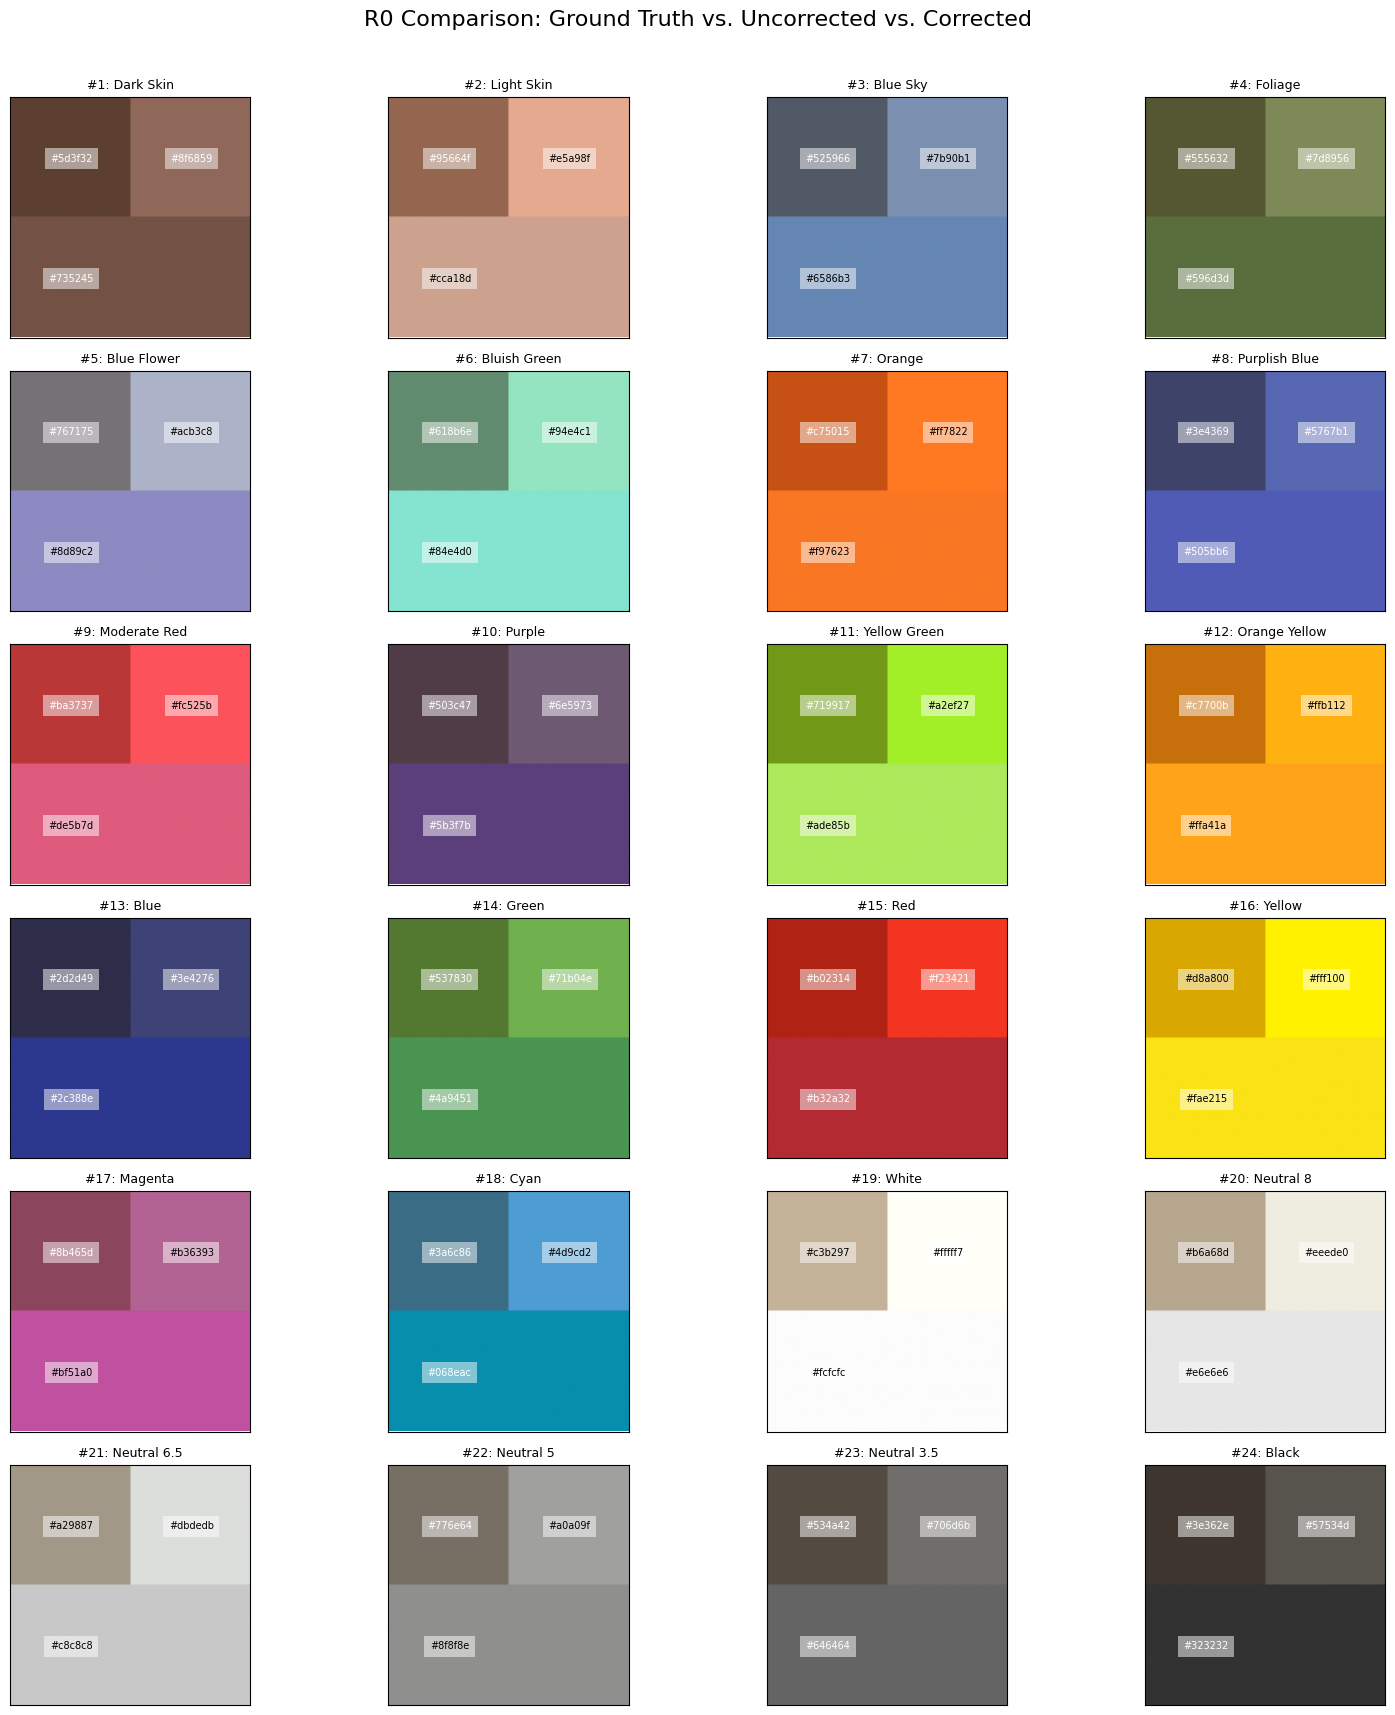

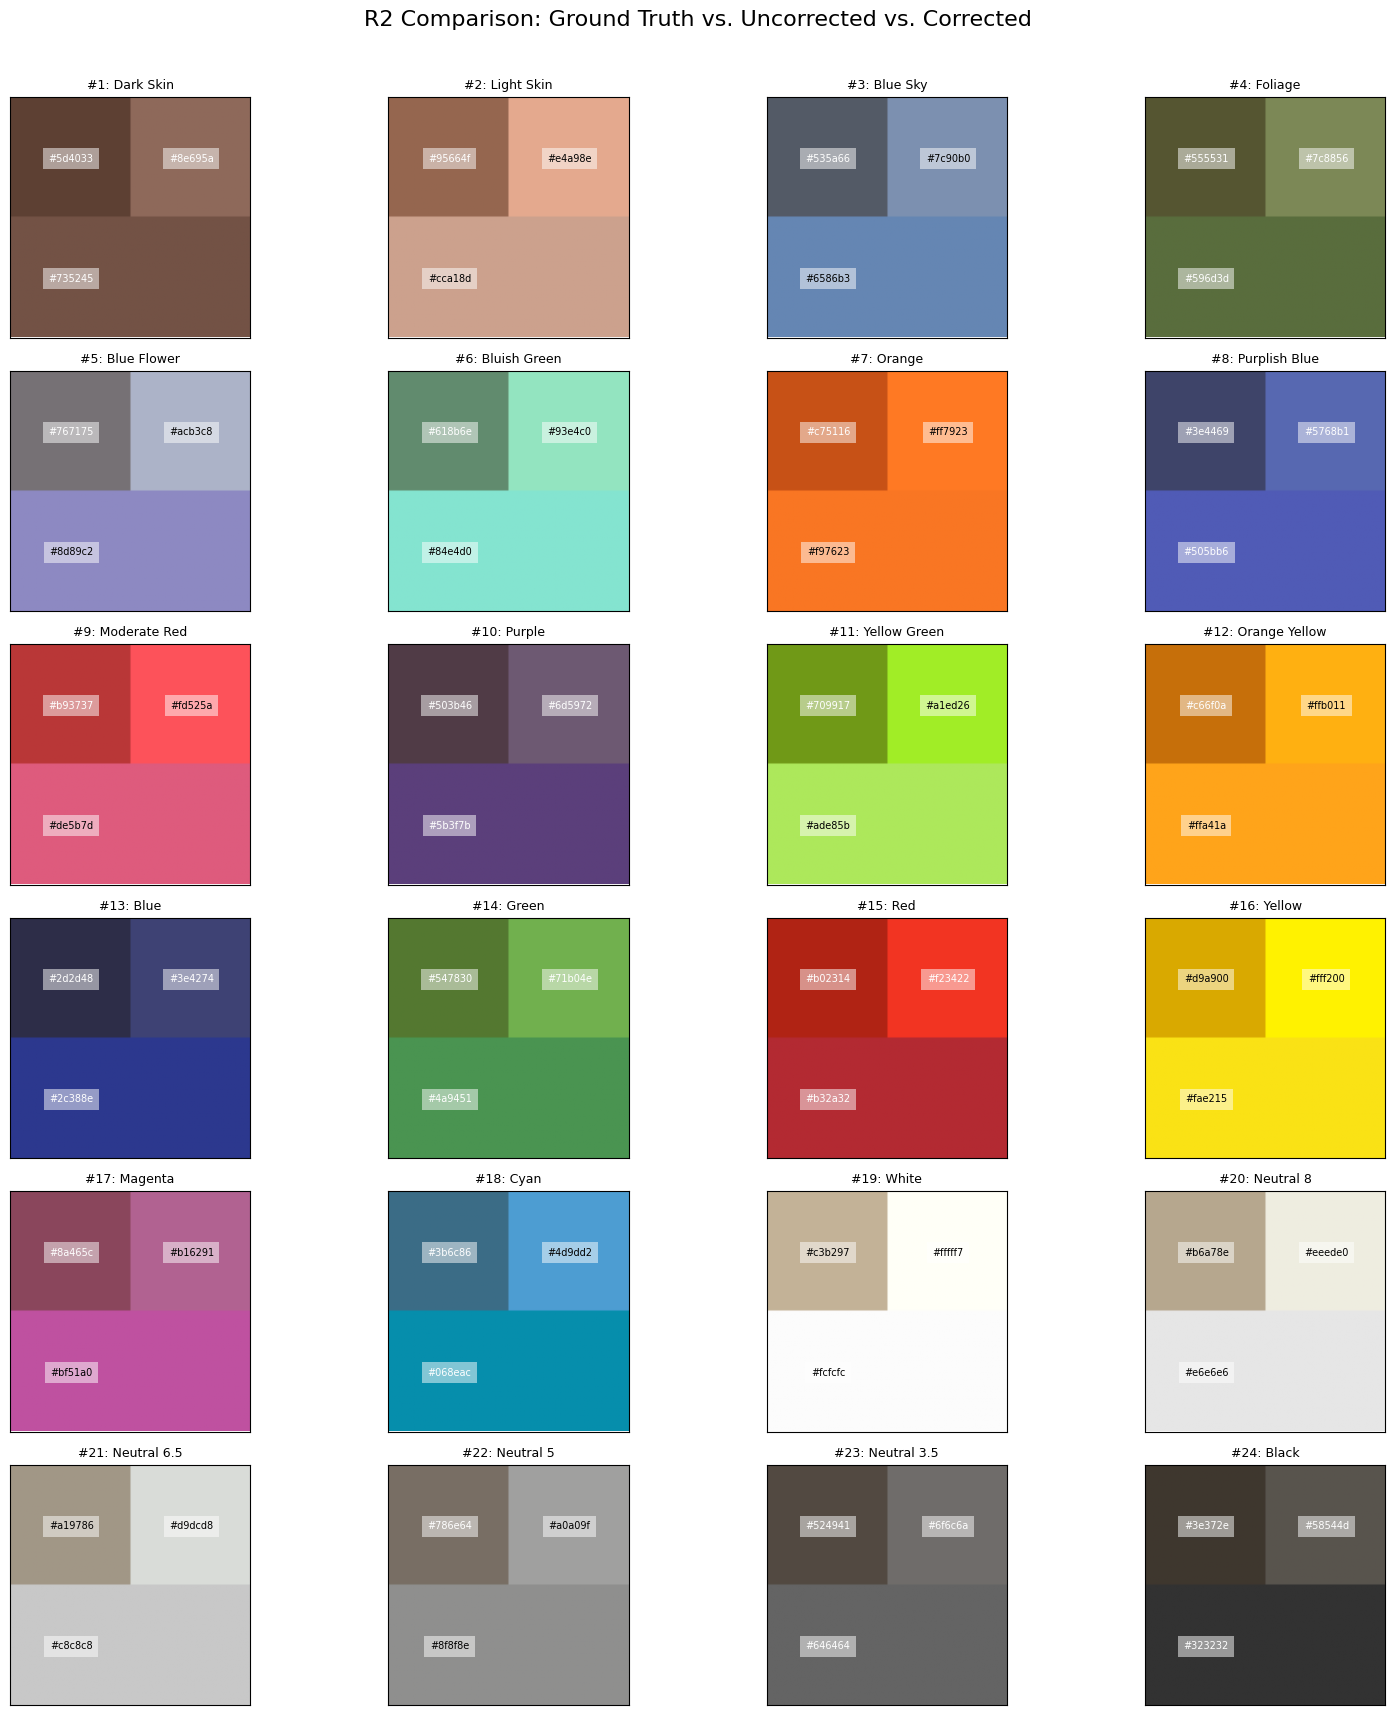

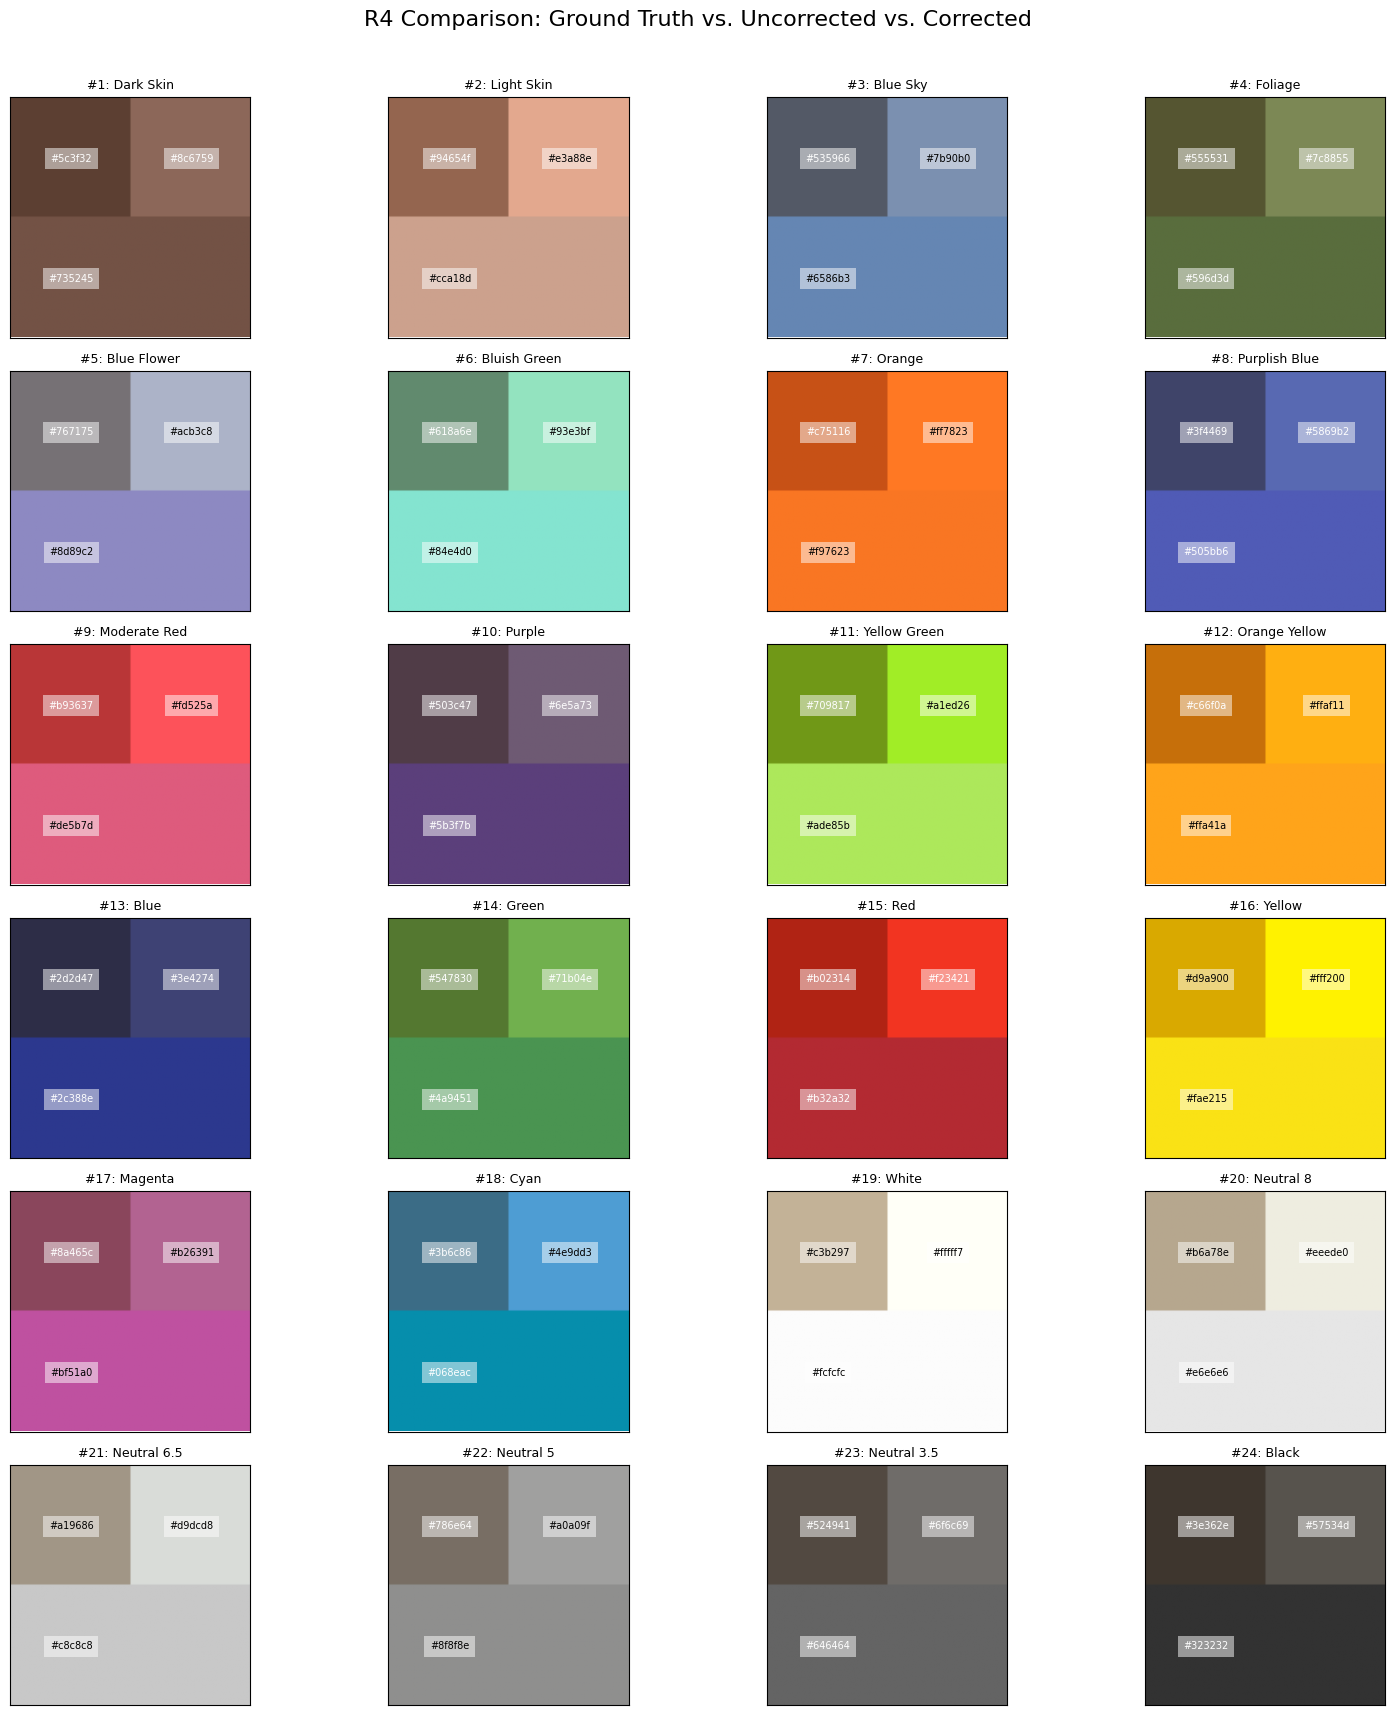

In [173]:
plotAllRadius()

In [111]:
df_final_comparison_r0 = df_final_comparison[[
    'sample_number', 'label',
    'color_r0_R', 'color_r0_G', 'color_r0_B',
    'correction_r0_R', 'correction_r0_G', 'correction_r0_B',
    'gt__R', 'gt__G', 'gt__B'
]]
df_final_comparison_r0.head()

sample_number        label  color_r0_R  color_r0_G  color_r0_B  \
0              1    Dark Skin       107.3        78.8        61.0   
1              2   Light Skin       163.4       121.1        98.2   
2              3     Blue Sky        95.2       113.4       139.9   
3              4      Foliage        91.6       103.0        63.6   
4              5  Blue Flower       131.5       132.6       146.7   

   correction_r0_R  correction_r0_G  correction_r0_B  gt__R  gt__G  gt__B  
0            157.6            117.5             95.2    115     82     69  
1            235.1            179.7            151.8    204    161    141  
2            136.7            166.8            216.9    101    134    179  
3            129.7            148.5             95.4     89    109     61  
4            181.9            187.3            216.7    141    137    194

In [112]:
def plot_rgb_kde(df, radius_str):
    fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True, sharey=True)
    fig.suptitle(f'RGB Kernel Density Estimation for {radius_str}', fontsize=16)

    color_channels = ['R', 'G', 'B']
    titles = ['Red Channel', 'Green Channel', 'Blue Channel']

    for i, channel in enumerate(color_channels):
        sns.kdeplot(df[f'color_{radius_str}_{channel}'], ax=axes[i], label='Uncorrected', color='red', fill=True, alpha=0.3)
        sns.kdeplot(df[f'correction_{radius_str}_{channel}'], ax=axes[i], label='Corrected', color='green', fill=True, alpha=0.3)
        sns.kdeplot(df[f'gt__{channel}'], ax=axes[i], label='Ground Truth', color='blue', fill=True, alpha=0.3)

        axes[i].set_title(titles[i])
        axes[i].set_xlabel(f'Pixel Value ({channel})')
        axes[i].set_ylabel('Density')
        axes[i].set_xlim(0, 255) # RGB values are typically 0-255
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("KDE plotting function 'plot_rgb_kde' defined.")

KDE plotting function 'plot_rgb_kde' defined.


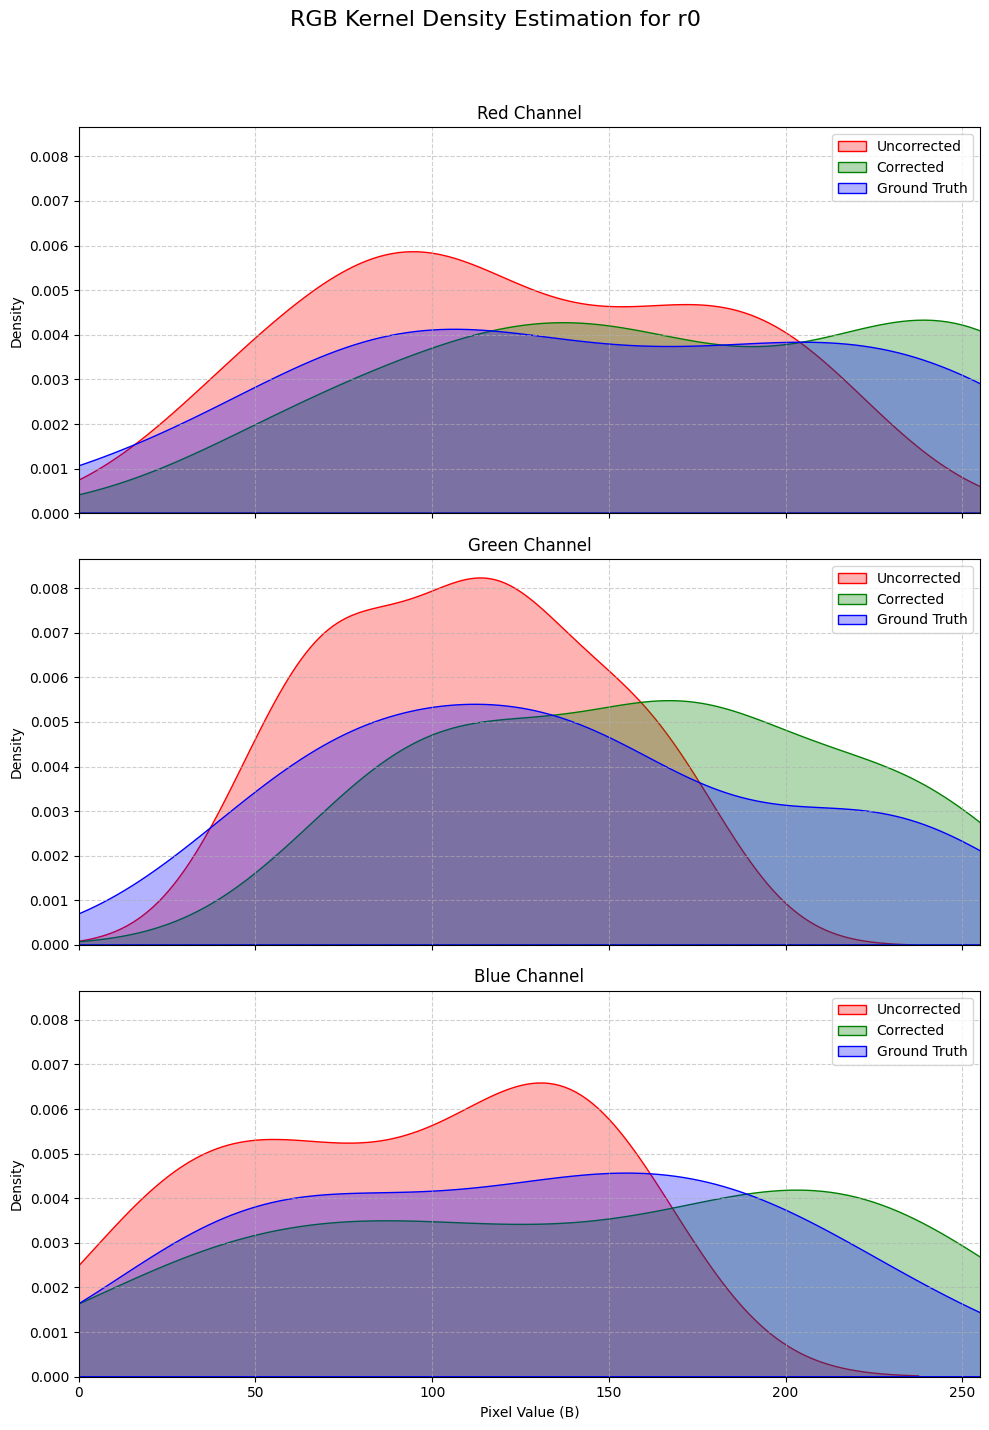

In [113]:
plot_rgb_kde(df_final_comparison_r0, 'r0')

In [114]:
import seaborn as sns # Re-import seaborn to ensure it's available

def plot_rgb_kde(df, radius_str):
    fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True, sharey=True)
    fig.suptitle(f'RGB Kernel Density Estimation for {radius_str}', fontsize=16)

    color_channels = ['R', 'G', 'B']
    titles = ['Red Channel', 'Green Channel', 'Blue Channel']

    for i, channel in enumerate(color_channels):
        sns.kdeplot(df[f'color_{radius_str}_{channel}'], ax=axes[i], label='Uncorrected', color='red', fill=True, alpha=0.3)
        sns.kdeplot(df[f'correction_{radius_str}_{channel}'], ax=axes[i], label='Corrected', color='green', fill=True, alpha=0.3)
        sns.kdeplot(df[f'gt__{channel}'], ax=axes[i], label='Ground Truth', color='blue', fill=True, alpha=0.3)

        axes[i].set_title(titles[i])
        axes[i].set_xlabel(f'Pixel Value ({channel})')
        axes[i].set_ylabel('Density')
        axes[i].set_xlim(0, 255) # RGB values are typically 0-255
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("KDE plotting function 'plot_rgb_kde' defined with seaborn import.")

KDE plotting function 'plot_rgb_kde' defined with seaborn import.


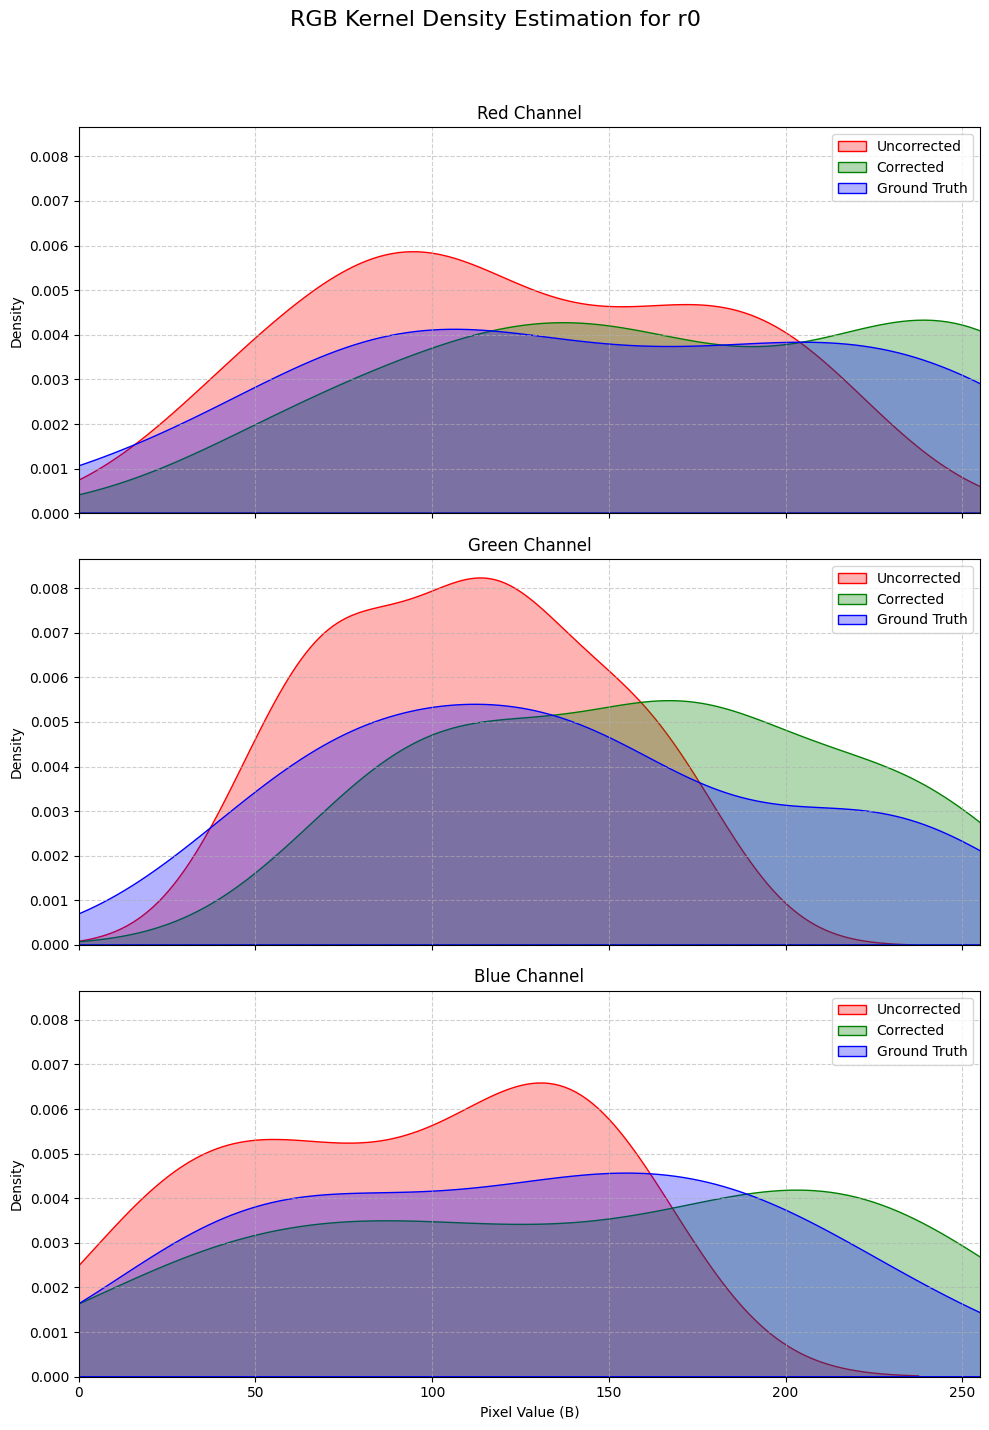

In [115]:
plot_rgb_kde(df_final_comparison_r0, 'r0')

/tmp/ipython-input-678193652.py:50: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(gt_data, ax=ax, color=color, linestyle='dotted', fill=False, alpha=0.7)
/tmp/ipython-input-678193652.py:50: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(gt_data, ax=ax, color=color, linestyle='dotted', fill=False, alpha=0.7)
/tmp/ipython-input-678193652.py:50: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(gt_data, ax=ax, color=color, linestyle='dotted', fill=False, alpha=0.7)
/tmp/ipython-input-678193652.py:50: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(gt_data, ax=ax, color=color, linestyle='dotted', fill=False, alpha=0.7)
/tmp/ipython-input-678193652.py:50: UserWarning:

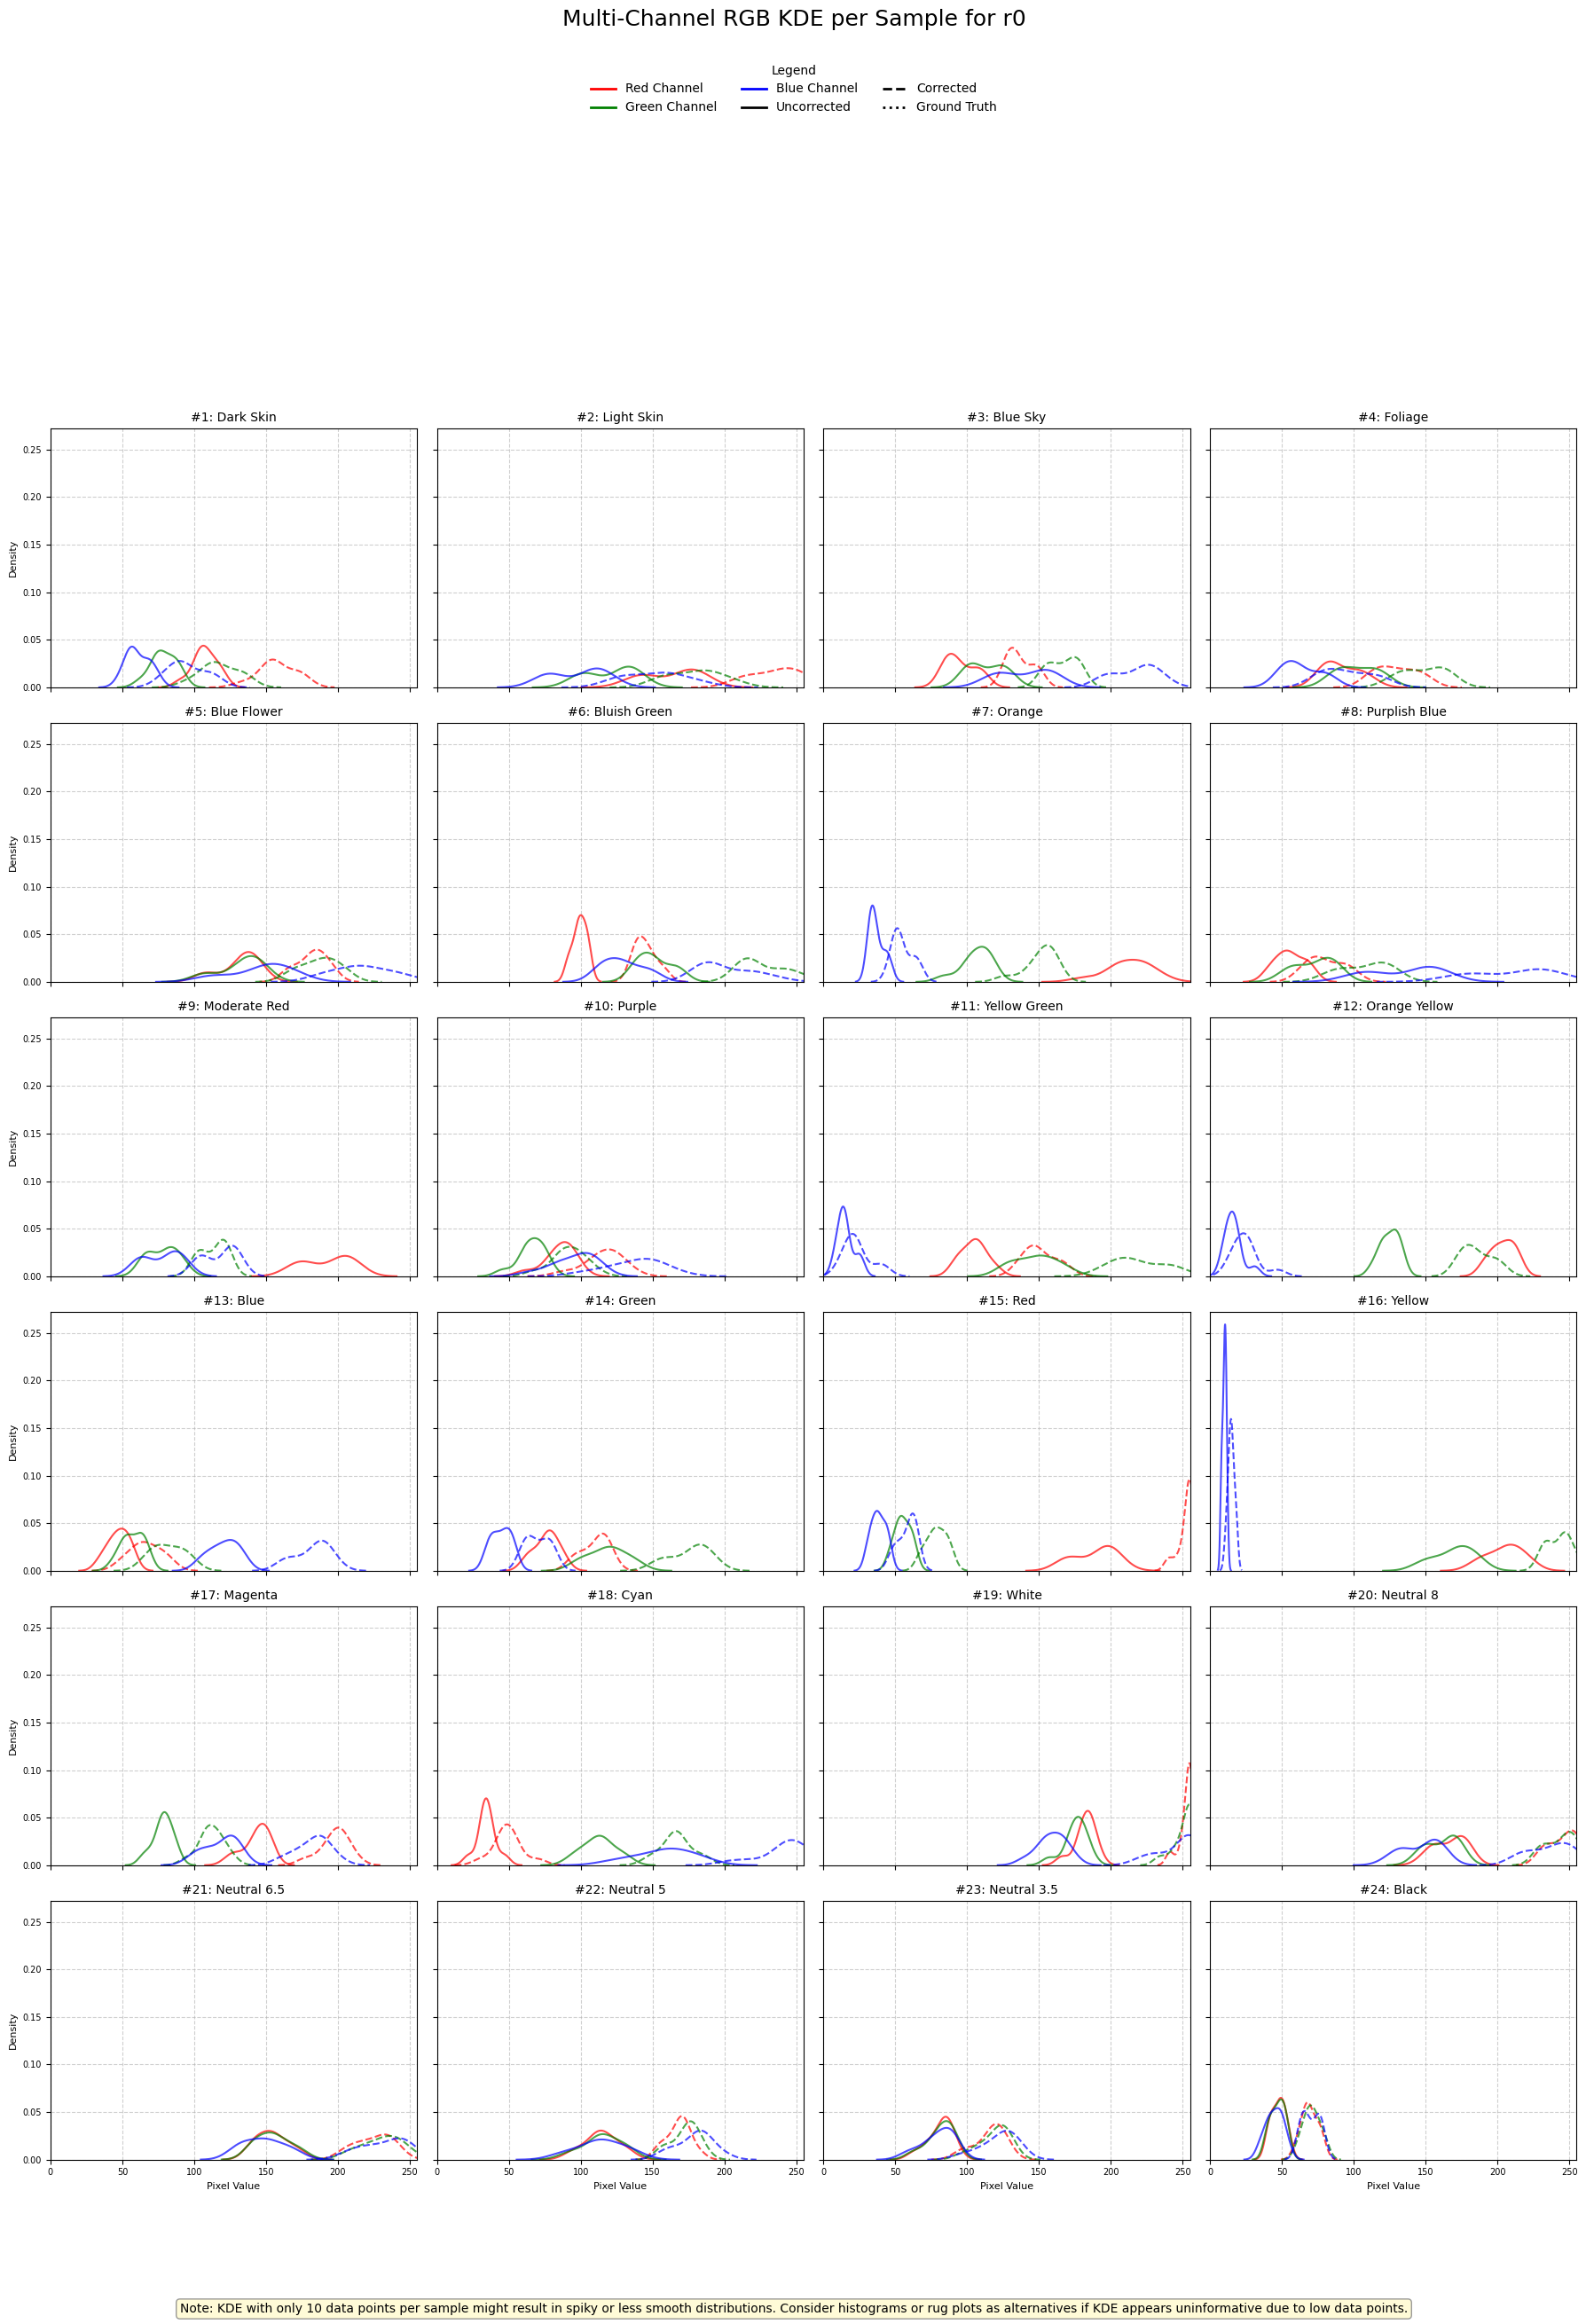

KDE plotting function 'plot_multi_channel_kde_per_sample' defined and executed for r0.


In [116]:
import matplotlib.lines as mlines

def plot_multi_channel_kde_per_sample(df, radius_str):
    num_samples = df['sample_number'].nunique()
    rows = 6
    cols = 4

    if num_samples > rows * cols:
        print(f"Warning: More samples ({num_samples}) than subplots ({rows*cols}). Only the first {rows*cols} will be plotted.")

    fig, axes = plt.subplots(rows, cols, figsize=(20, 25), sharex=True, sharey=True)
    axes = axes.flatten()

    # Get unique sample numbers and labels from the full DataFrame
    unique_samples_info = df[['sample_number', 'label']].drop_duplicates().sort_values('sample_number')

    for i, (sample_num, sample_label) in enumerate(unique_samples_info.values):
        if i >= len(axes): # Ensure we don't go out of bounds if num_samples > rows*cols
            break

        ax = axes[i]
        # Filter the original DataFrame to get all 10 measurements for the current sample
        df_sample = df[df['sample_number'] == sample_num]

        # Extract ground truth values (they are constant per sample)
        gt_r = df_sample['gt__R'].iloc[0]
        gt_g = df_sample['gt__G'].iloc[0]
        gt_b = df_sample['gt__B'].iloc[0]

        # Create Series for ground truth to plot with kdeplot
        gt_r_series = pd.Series([gt_r] * len(df_sample))
        gt_g_series = pd.Series([gt_g] * len(df_sample))
        gt_b_series = pd.Series([gt_b] * len(df_sample))

        channel_colors = {'R': 'red', 'G': 'green', 'B': 'blue'}
        channel_data_map = {
            'R': (df_sample[f'color_{radius_str}_R'], df_sample[f'correction_{radius_str}_R'], gt_r_series),
            'G': (df_sample[f'color_{radius_str}_G'], df_sample[f'correction_{radius_str}_G'], gt_g_series),
            'B': (df_sample[f'color_{radius_str}_B'], df_sample[f'correction_{radius_str}_B'], gt_b_series)
        }

        for channel, color in channel_colors.items():
            uncorr_data, corr_data, gt_data = channel_data_map[channel]

            # Uncorrected (solid line)
            sns.kdeplot(uncorr_data, ax=ax, color=color, linestyle='solid', fill=False, alpha=0.7)
            # Corrected (dashed line)
            sns.kdeplot(corr_data, ax=ax, color=color, linestyle='dashed', fill=False, alpha=0.7)
            # Ground Truth (dotted line)
            sns.kdeplot(gt_data, ax=ax, color=color, linestyle='dotted', fill=False, alpha=0.7)

        ax.set_title(f"#{int(sample_num)}: {sample_label}", fontsize=10)
        ax.set_xlabel('Pixel Value', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.set_xlim(0, 255)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.tick_params(axis='both', which='major', labelsize=7)

    # Hide any unused subplots if num_samples is less than rows * cols
    for j in range(num_samples, len(axes)):
        if j < len(axes):
            fig.delaxes(axes[j])

    # Create proxy Line2D objects for the comprehensive legend
    legend_elements = [
        mlines.Line2D([0], [0], color='red', lw=2, label='Red Channel', linestyle='solid'),
        mlines.Line2D([0], [0], color='green', lw=2, label='Green Channel', linestyle='solid'),
        mlines.Line2D([0], [0], color='blue', lw=2, label='Blue Channel', linestyle='solid'),
        mlines.Line2D([0], [0], color='black', lw=2, label='Uncorrected', linestyle='solid'),
        mlines.Line2D([0], [0], color='black', lw=2, label='Corrected', linestyle='dashed'),
        mlines.Line2D([0], [0], color='black', lw=2, label='Ground Truth', linestyle='dotted')
    ]

    # Add the common legend to the entire figure
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.02),
               ncol=3, title="Legend", fontsize='medium', frameon=False)

    # Set main title
    fig.suptitle(f'Multi-Channel RGB KDE per Sample for {radius_str}', fontsize=18, y=1.04)

    # Add explanatory text note
    fig.text(0.5, 0.00,
             'Note: KDE with only 10 data points per sample might result in spiky or less smooth distributions. '
             'Consider histograms or rug plots as alternatives if KDE appears uninformative due to low data points.',
             ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="lemonchiffon", ec="gray", lw=1, alpha=0.8))

    # Adjust subplot parameters for a tight layout, leaving space for title, legend, and text
    plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.88])

    plt.show()

# Call the function with the main DataFrame 'df' (from the pipeline output) and 'r0'
plot_multi_channel_kde_per_sample(df, 'r0')

print("KDE plotting function 'plot_multi_channel_kde_per_sample' defined and executed for r0.")

TypeError: FigureBase.text() missing 1 required positional argument: 's'

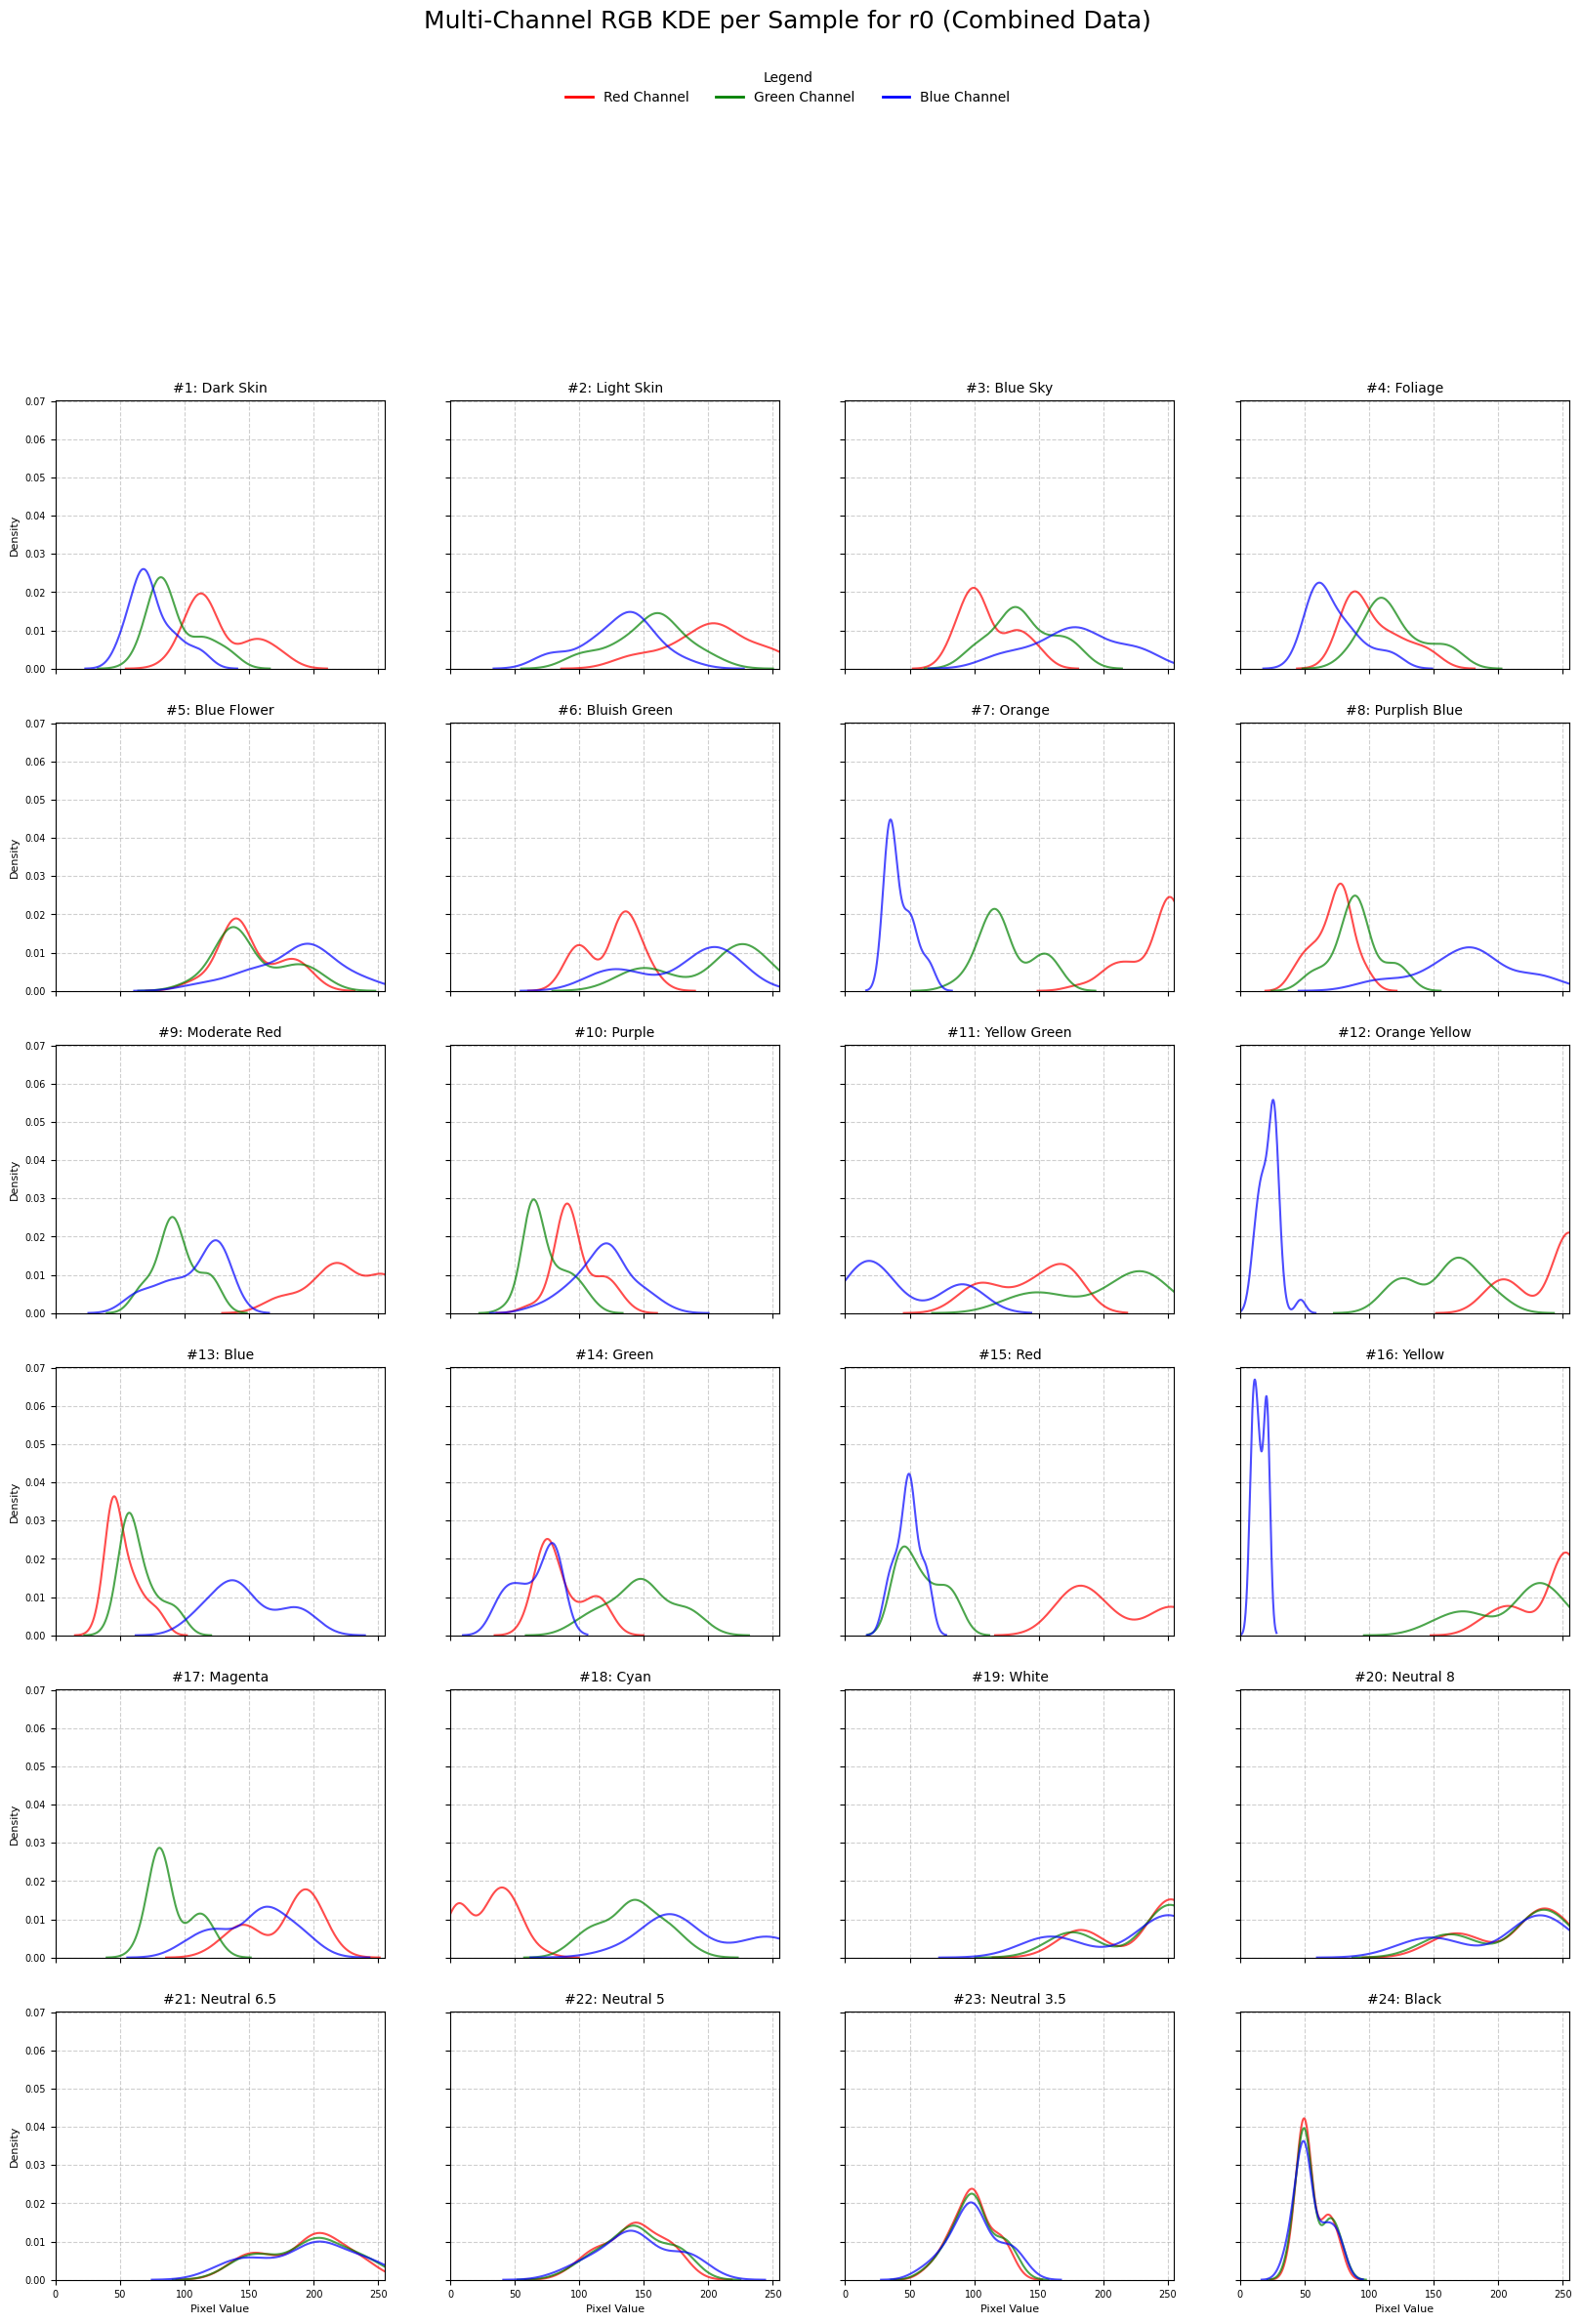

In [140]:
import matplotlib.lines as mlines

def plot_multi_channel_kde_per_sample(df, radius_str):
    num_samples = df['sample_number'].nunique()
    rows = 6
    cols = 4

    if num_samples > rows * cols:
        print(f"Warning: More samples ({num_samples}) than subplots ({rows*cols}). Only the first {rows*cols} will be plotted.")

    fig, axes = plt.subplots(rows, cols, figsize=(20, 25), sharex=True, sharey=True)
    axes = axes.flatten()

    # Get unique sample numbers and labels from the full DataFrame
    unique_samples_info = df[['sample_number', 'label']].drop_duplicates().sort_values('sample_number')

    for i, (sample_num, sample_label) in enumerate(unique_samples_info.values):
        if i >= len(axes): # Ensure we don't go out of bounds if num_samples > rows*cols
            break

        ax = axes[i]
        # Filter the original DataFrame to get all 10 measurements for the current sample
        df_sample = df[df['sample_number'] == sample_num]

        # Extract ground truth values (they are constant per sample)
        gt_r = df_sample['gt__R'].iloc[0]
        gt_g = df_sample['gt__G'].iloc[0]
        gt_b = df_sample['gt__B'].iloc[0]

        # Create Series for ground truth to plot with kdeplot
        gt_r_series = pd.Series([gt_r] * len(df_sample))
        gt_g_series = pd.Series([gt_g] * len(df_sample))
        gt_b_series = pd.Series([gt_b] * len(df_sample))

        channel_colors = {'R': 'red', 'G': 'green', 'B': 'blue'}
        channel_data_map = {
            'R': (df_sample[f'color_{radius_str}_R'], df_sample[f'correction_{radius_str}_R'], gt_r_series),
            'G': (df_sample[f'color_{radius_str}_G'], df_sample[f'correction_{radius_str}_G'], gt_g_series),
            'B': (df_sample[f'color_{radius_str}_B'], df_sample[f'correction_{radius_str}_B'], gt_b_series)
        }

        for channel, color in channel_colors.items():
            uncorr_data, corr_data, gt_data = channel_data_map[channel]

            # Concatenate uncorrected, corrected, and ground truth data for the current channel
            combined_channel_data = pd.concat([uncorr_data, corr_data, gt_data])

            # Plot a single KDE for the combined data of this channel
            sns.kdeplot(combined_channel_data, ax=ax, color=color, linestyle='solid', fill=False, alpha=0.7, warn_singular=False)

        ax.set_title(f"#{int(sample_num)}: {sample_label}", fontsize=10)
        ax.set_xlabel('Pixel Value', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.set_xlim(0, 255)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.tick_params(axis='both', which='major', labelsize=7)

    # Hide any unused subplots if num_samples is less than rows * cols
    for j in range(num_samples, len(axes)):
        if j < len(axes):
            fig.delaxes(axes[j])

    # Create proxy Line2D objects for the comprehensive legend
    legend_elements = [
        mlines.Line2D([0], [0], color='red', lw=2, label='Red Channel', linestyle='solid'),
        mlines.Line2D([0], [0], color='green', lw=2, label='Green Channel', linestyle='solid'),
        mlines.Line2D([0], [0], color='blue', lw=2, label='Blue Channel', linestyle='solid')
    ]

    # Add the common legend to the entire figure
    fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.02),
               ncol=3, title="Legend", fontsize='medium', frameon=False)

    # Set main title
    fig.suptitle(f'Multi-Channel RGB KDE per Sample for {radius_str} (Combined Data)', fontsize=18, y=1.04)

    # Add explanatory text note
    fig.text(0.5, 0.00, ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="lemonchiffon", ec="gray", lw=1, alpha=0.8))

    # Adjust subplot parameters for a tight layout, leaving space for title, legend, and text
    plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.88])

    plt.show()

# Call the function with the main DataFrame 'df' (from the pipeline output) and 'r0'
plot_multi_channel_kde_per_sample(df, 'r0')

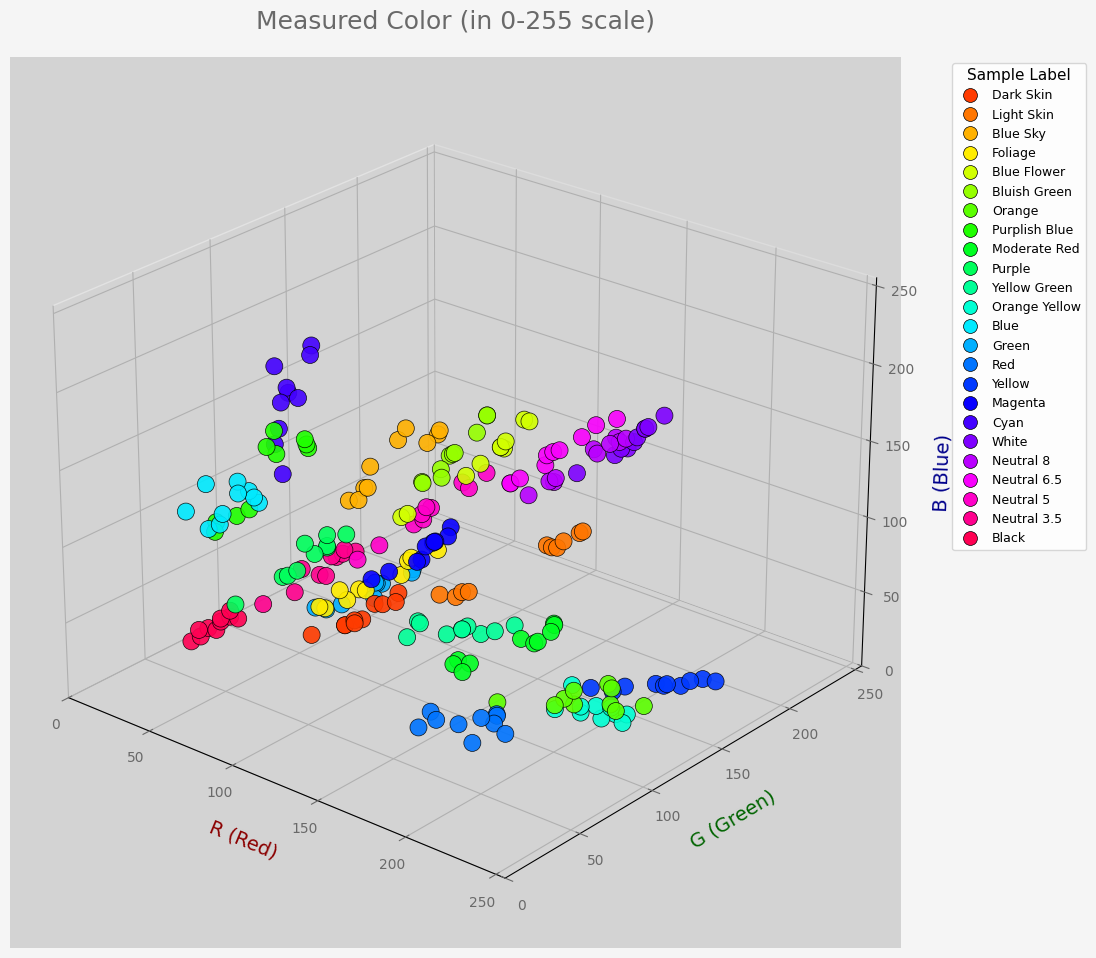

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import to_rgba # For better color handling

# --- Assume df exists with 'color_r0_R', 'color_r0_G', 'color_r0_B', 'label' ---
# Example df for demonstration if you don't have it loaded
# np.random.seed(42) # for reproducibility
# df = pd.DataFrame({
#     'color_r0_R': np.random.randint(0, 256, 100),
#     'color_r0_G': np.random.randint(0, 256, 100),
#     'color_r0_B': np.random.randint(0, 256, 100),
#     'label': np.random.choice([f'Label {i}' for i in range(10)], 100)
# })
# Add more labels to test palette
# df['label'] = np.random.choice([f'Sample {i}' for i in range(24)], len(df))

# Use the actual column names from your plot
R_COL, G_COL, B_COL = 'color_r0_R', 'color_r0_G', 'color_r0_B'


# 1. Setup the figure and 3D axis with a darker background for contrast
fig = plt.figure(figsize=(12, 10), facecolor='whitesmoke') # Lighter background for the figure
ax = fig.add_subplot(projection='3d')

# Set subplot background for 3D plot
ax.set_facecolor('lightgray') # A subtle gray can look more sophisticated
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.edgecolor = 'lightgray'
ax.yaxis.pane.edgecolor = 'lightgray'
ax.zaxis.pane.edgecolor = 'lightgray'


# 2. Get color mapping from Seaborn
unique_labels = (df['label'].unique()) # Sort labels for consistent legend order
# Using 'hsv' or 'tab20' can sometimes have similar colors.
# 'viridis' or 'plasma' or custom palettes can offer better distinction.
# For many categories, 'tab20' is a good start, but 'viridis' or 'plasma' are perceptually uniform.
# Let's try 'hsv' for more distinct colors, or 'tab20' if you prefer.
palette = sns.color_palette('hsv', n_colors=len(unique_labels)) # 'hsv' provides good spread
label_to_color = dict(zip(unique_labels, palette))

# Map original colors to RGBA for consistent alpha handling
df['color_map'] = df['label'].map(label_to_color).apply(lambda x: to_rgba(x, alpha=0.8))


# 3. Plot the data using the 3D ax.scatter method
scatter = ax.scatter(
    xs=df[R_COL],
    ys=df[G_COL],
    zs=df[B_COL],
    c=df['color_map'], # Use the mapped colors with alpha included
    s=150,             # Slightly larger size for better visibility
    edgecolors='black', # Add a thin black border for definition
    linewidths=0.5,     # Thin border
    alpha=0.9,          # Adjust alpha here (can be redundant if in color_map)
    marker='o',
    depthshade=True     # Add shading to give a sense of depth
)

# 4. Set labels and title
ax.set_title('Measured Color (in 0-255 scale)', fontsize=18, color='dimgray', pad=20) # Title style
ax.set_xlabel('R (Red)', fontsize=14, color='darkred', labelpad=10) # X-axis label style
ax.set_ylabel('G (Green)', fontsize=14, color='darkgreen', labelpad=10) # Y-axis label style
ax.set_zlabel('B (Blue)', fontsize=14, color='darkblue', labelpad=10) # Z-axis label style

# Set tick parameters
ax.tick_params(axis='x', labelsize=10, colors='dimgray')
ax.tick_params(axis='y', labelsize=10, colors='dimgray')
ax.tick_params(axis='z', labelsize=10, colors='dimgray')

# 5. Create a legend
legend_handles = [plt.Line2D([0], [0], marker='o', color=label_to_color[label],
                             linestyle='', ms=10, label=label, markeredgecolor='black', markeredgewidth=0.5)
                  for label in unique_labels]

ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1),
          loc='upper left', title='Sample Label', fontsize=9, title_fontsize=11,
          facecolor='white', edgecolor='lightgray', framealpha=0.9)


# 6. Adjust View and Limits
ax.view_init(elev=25, azim=-50) # New default view angle for better spread and less overlap
# Set explicit limits to fill the space better, or to match 0-255 cube
ax.set_xlim(0, 255)
ax.set_ylim(0, 255)
ax.set_zlim(0, 255)

# Optional: Adjust aspect ratio for a true cube representation
# ax.set_box_aspect([1,1,1]) # Not directly supported by older matplotlib, calculate manually

# 7. Add Grid (Optional, can be removed for cleaner look if preferred)
ax.grid(True, linestyle=':', alpha=0.5, color='gray')


plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent legend overlap
plt.show()

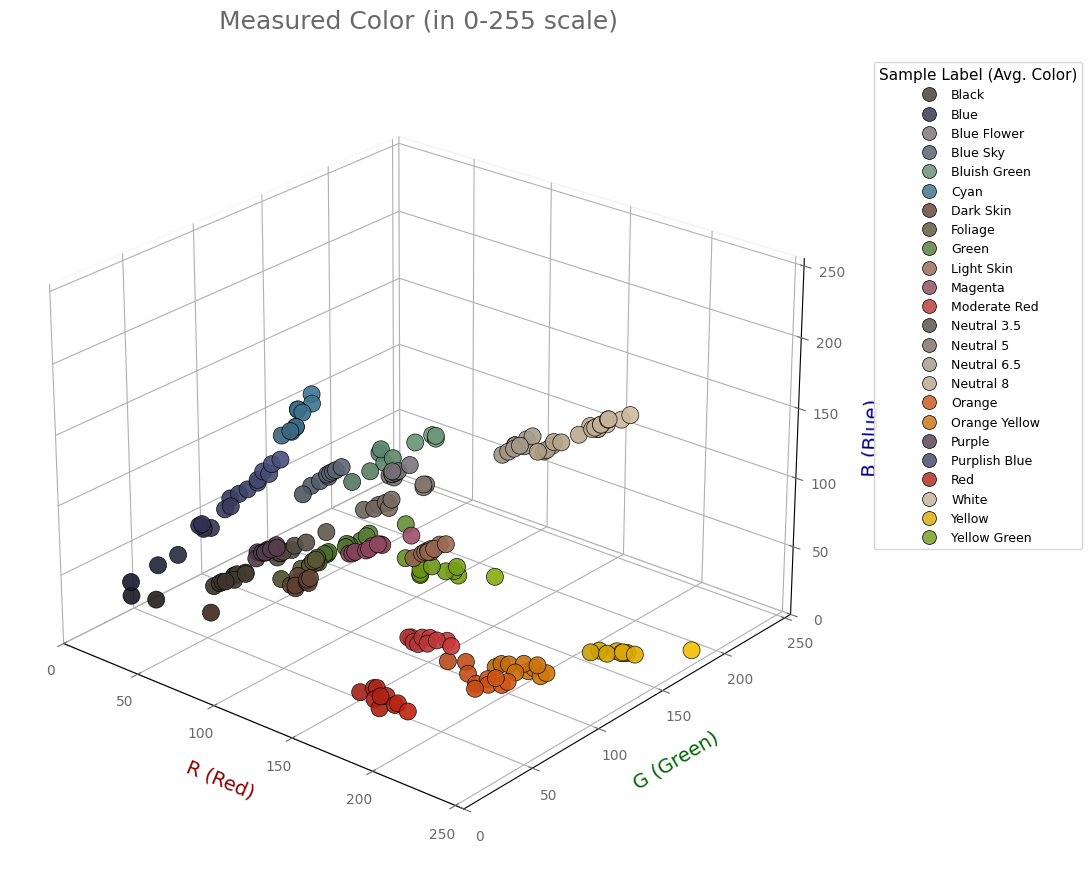

In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import to_rgba # For better color handling

# Use the actual column names from your plot
R_COL, G_COL, B_COL = 'color_r0_R', 'color_r0_G', 'color_r0_B'

# 1. Setup the figure and 3D axis with a darker background for contrast
fig = plt.figure(figsize=(12, 10), facecolor='white') # Lighter background for the figure
ax = fig.add_subplot(projection='3d')

# Set subplot background for 3D plot
ax.set_facecolor('white') # A subtle gray can look more sophisticated
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.edgecolor = 'white'
ax.yaxis.pane.edgecolor = 'white'
ax.zaxis.pane.edgecolor = 'white'

# --- Modifications start here ---

# Prepare colors for each point based on its own RGB values
# Normalize to 0-1 range for matplotlib
point_colors_normalized = df[[R_COL, G_COL, B_COL]].values / 255.0

# Calculate average colors for each label for the legend
avg_colors_for_legend = df.groupby('label')[[R_COL, G_COL, B_COL]].mean().reset_index()
# Sort to ensure legend order matches unique_labels for consistency
avg_colors_for_legend = avg_colors_for_legend.sort_values('label')

# Map average RGB to normalized RGBA for legend handles
avg_colors_for_legend['rgba'] = avg_colors_for_legend[[R_COL, G_COL, B_COL]].apply(
    lambda row: to_rgba((row[R_COL]/255, row[G_COL]/255, row[B_COL]/255), alpha=0.8), axis=1
)

# 3. Plot the data using the 3D ax.scatter method
scatter = ax.scatter(
    xs=df[R_COL],
    ys=df[G_COL],
    zs=df[B_COL],
    c=point_colors_normalized, # Use the actual measured colors for points
    s=150,             # Slightly larger size for better visibility
    edgecolors='black', # Add a thin black border for definition
    linewidths=0.5,     # Thin border
    alpha=0.9,          # Adjust alpha here
    marker='o',
    depthshade=True     # Add shading to give a sense of depth
)

# 4. Set labels and title
ax.set_title('Measured Color (in 0-255 scale)', fontsize=18, color='dimgray', pad=20) # Title style
ax.set_xlabel('R (Red)', fontsize=14, color='darkred', labelpad=10) # X-axis label style
ax.set_ylabel('G (Green)', fontsize=14, color='darkgreen', labelpad=10) # Y-axis label style
ax.set_zlabel('B (Blue)', fontsize=14, color='darkblue', labelpad=10) # Z-axis label style

# Set tick parameters
ax.tick_params(axis='x', labelsize=10, colors='dimgray')
ax.tick_params(axis='y', labelsize=10, colors='dimgray')
ax.tick_params(axis='z', labelsize=10, colors='dimgray')

# 5. Create a legend using the average colors for each label
unique_labels_sorted = avg_colors_for_legend['label'].tolist()
legend_handles = [
    plt.Line2D([0], [0], marker='o', color=avg_colors_for_legend.loc[avg_colors_for_legend['label'] == label, 'rgba'].iloc[0],
               linestyle='', ms=10, label=label, markeredgecolor='black', markeredgewidth=0.5)
    for label in unique_labels_sorted
]

ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1),
          loc='upper left', title='Sample Label (Avg. Color)', fontsize=9, title_fontsize=11,
          facecolor='white', edgecolor='lightgray', framealpha=0.9)


# 6. Adjust View and Limits
ax.view_init(elev=25, azim=-50) # New default view angle for better spread and less overlap
# Set explicit limits to fill the space better, or to match 0-255 cube
ax.set_xlim(0, 255)
ax.set_ylim(0, 255)
ax.set_zlim(0, 255)

# Optional: Adjust aspect ratio for a true cube representation
# ax.set_box_aspect([1,1,1]) # Not directly supported by older matplotlib, calculate manually

# 7. Add Grid (Optional, can be removed for cleaner look if preferred)
ax.grid(True, linestyle=':', alpha=0.5, color='gray')


plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to prevent legend overlap
plt.show()